In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [155]:
nx = 41
ny = 41
nt = 500
# c = 1 I don't know what this does
dx = 8 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

rho = 10
nu = .001
dt = .0001
l2_target = 1e-4

In [147]:
# function for creating initial conditions
def init_arrays():
    u = numpy.zeros((ny, nx))
    v = numpy.zeros((ny, nx))
    p = numpy.zeros((ny, nx))
    b = numpy.zeros((ny, nx))
    pt = numpy.ndarray((nt,ny,nx))
    
    p[-1, 10:31] = 100 # beginning pressure pulse
    return u, v, p, b, pt

In [148]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

In [156]:
def pressure_poisson(p, dx, dy, b, nt, l2_target):
    pn = numpy.empty_like(p)
    pn = p.copy()
    iter_diff = l2_target + 1
    n = 0
    while iter_diff > l2_target:
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] ##dp/dy = 0 at x = 2
        p[0, :] = p[1, :]  ##dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]    ##dp/dx = 0 at x = 0
        # driving periodic pressure boundary condition
        if nt == 0: #nt%100 == 0:
            p[-1, 10:31] = 100 #p = 100 at y = 2, nt = 0, and every 100 time steps
            p[-1, :10] = 0
            p[-1, 30:] = 0
        else:
            p[-1, :] = 0       #p = 0 at y = 2 all other time steps
            
        if n%10==0:
            iter_diff = numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))
        n += 1
    return p

In [150]:
def ink_channel_flow(nt, u, v, dt, dx, dy, p, pt, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b, n, l2_target)
        pt[n] = p.copy()
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :] = 0
        u[:, 0] = u[:, 1]
        u[:, -1] = u[:, -2]
        u[-1, :] = 0    
        v[0, :] = 0
        v[-1, :]=0
        v[:, 0] = 0
        v[:, -1] = 0
        
        
    return u, v, p, pt

In [157]:
u, v, p, b, pt = init_arrays()
u, v, p, pt = ink_channel_flow(nt, u, v, dt, dx, dy, p, pt, rho, nu)

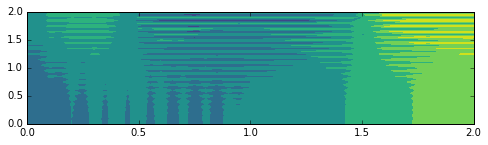

In [176]:
fig = pyplot.figure(figsize=(8,2), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, pt[255], cmap=cm.viridis); 

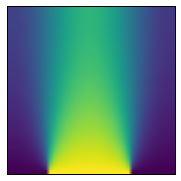

In [164]:
fig = pyplot.figure(figsize=(8,3))
pyplot.xticks([]), pyplot.yticks([]);
im = pyplot.imshow(pt[0], cmap=cm.viridis)

In [18]:
def init():
    im.set_data(numpy.zeros((ny,nx)))
    return im,
def animate(data):
    im.set_array(data)
    return im,

In [162]:
anim = animation.FuncAnimation(fig, animate, frames=pt, interval=75)

In [163]:
HTML(anim.to_html5_video())

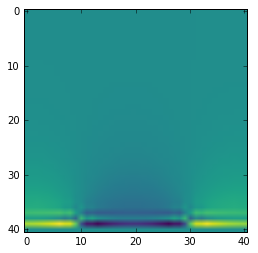

In [137]:
pyplot.imshow(pt[6],cmap=cm.viridis)

In [130]:
for i in range(0,100):
    print(pt[i].max())

100.0
18.9890191635
4.24464730376
2.93915899927
2.19975251203
1.74607170484
1.52061278252
1.34321251563
1.19891619791
1.07870712201
0.97713152637
0.890203763283
0.827452718164
0.778068608717
0.734590941553
0.695051296426
0.658935287046
0.625890644623
0.597119381768
0.573230629601
0.550986728625
0.53017034873
0.510527829064
0.492076206013
0.474665398091
0.458161114146
0.442499126658
0.427669995165
0.413564975577
0.400147803075
0.387365007236
0.375179929259
0.36450634644
0.355512210596
0.346909459116
0.33862811072
0.330669137986
0.322998911136
0.315645694931
0.308557434628
0.301728639494
0.295163911867
0.288844332664
0.282746765701
0.276841319021
0.271108429932
0.265546802659
0.260137696414
0.254897728407
0.249793944635
0.244830137826
0.240001847924
0.2353026544
0.230713806675
0.226254869552
0.221900015063
0.217661885236
0.213528742677
0.2094967299
0.205564112354
0.201729554667
0.197999778804
0.194357072324
0.190815169181
0.187355256213
0.183982858291
0.180697790657
0.177490570984
0.1743

In [113]:
numpy.shape(pt[0])

(41, 41)